In [ ]:
%store -r

## Imports

In [1]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import NumeralTickFormatter
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.io import curdoc

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

import tensorflow as tf

from scipy import stats
import pandas as pd
import numpy as np 
import random

from datetime import datetime as dt
from datetime import timedelta
import calendar

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt

import MetaTrader5 as mt5

In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 1500)
curdoc().theme = 'caliber'

## Define dataframes for currencies

In [141]:
Currency_Columns = ["Date","Symbol","Long","Short","Change Long","Change Short","Net positions","Total positions","Open interest"]
CAD_df = pd.DataFrame(columns=Currency_Columns)
CHF_df = pd.DataFrame(columns=Currency_Columns)
GBP_df = pd.DataFrame(columns=Currency_Columns)
JPY_df = pd.DataFrame(columns=Currency_Columns)
EUR_df = pd.DataFrame(columns=Currency_Columns)
NZD_df = pd.DataFrame(columns=Currency_Columns)

In [142]:
CAD_df = pd.read_csv("CAD.csv",parse_dates=["Date"])
CHF_df = pd.read_csv("CHF.csv",parse_dates=["Date"])
GBP_df = pd.read_csv("GBP.csv",parse_dates=["Date"])
JPY_df = pd.read_csv("JPY.csv",parse_dates=["Date"])
EUR_df = pd.read_csv("EUR.csv",parse_dates=["Date"])
NZD_df = pd.read_csv("NZD.csv",parse_dates=["Date"])

## Defining trade dataframes

* Trade the biggest net position always ***v1***
* Trade when the change on one side is negative and the other is positivie ***v2***
* Trade the biggest position when the changes on this are positive and the opposite position are negative ***v3***

   _***s*** dataframes take the trades with the same condition but 7 days after the report's signal_

In [74]:
Trades_columns = ["Date","Position","Symbol","Duration","Result"]

Trades_v1 = pd.DataFrame(columns=Trades_columns)
Trades_v2 = pd.DataFrame(columns=Trades_columns)
Trades_v3 = pd.DataFrame(columns=Trades_columns)

In [75]:
Trades_v4 = pd.DataFrame(columns=Trades_columns)
Trades_v5 = pd.DataFrame(columns=Trades_columns)
Trades_v6 = pd.DataFrame(columns=Trades_columns)

## Browser headers and url

In [6]:
headers = [
           {'User-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0'},
           {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}]

In [7]:
url_current_report = "https://www.cftc.gov/dea/futures/deacmesf.htm"
url_current_home = "https://www.cftc.gov/MarketReports/CommitmentsofTraders/index.htm"
url_historical_home = "https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/index.htm"
structure_chicago_mercantile_exchange_url = "https://www.cftc.gov/sites/default/files/files/dea/cotarchives/{}/futures/deacmesf{}.htm"

## Retrieve the last report  (text)

In [8]:
request_current = requests.get(url_current_report, headers=random.choice(headers))

In [9]:
soup_current = BeautifulSoup(request_current.content,"html.parser")

In [10]:
reports_current = soup_current.find("pre").text.split("\r\n \r\n \r\n")

In [11]:
reports_current.remove("")

## Define the date of the lastest report

In [12]:
dateInfo = BeautifulSoup(requests.get(url_current_home, headers=random.choice(headers)).content,"html.parser").find_all("strong")[0].text.split(" ")
dateLast = dt(int(dt.now().year),int(list(calendar.month_name).index(dateInfo[2])),int(dateInfo[3].split(",")[0]))

## Retrieve locators of historical reports (url)

In [13]:
historical_urls = []

In [14]:
request_historical = requests.get(url_historical_home, headers=random.choice(headers))

In [15]:
soup_historical = BeautifulSoup(request_historical.content,"html.parser")

In [16]:
for table in soup_historical.find_all("table"):
    
    for element in table.find_all("a"):
        
        href = element.get("href")
        
        if href != None and href[-4:] != ".htm":
            
            if element.get("href")[-4:] == "html": addr = "/MarketReports/CommitmentsofTraders/HistoricalViewable/"+element.get("href")[:-5]  
            else: addr = element.get("href")[-6:]
                
            month = addr[-6:][:2]
            day = addr[-6:][2:4]
            year = addr[-6:][4:]
            historical_urls.append(structure_chicago_mercantile_exchange_url.format("20" + year,month+day+year))

## Helper function

In [17]:
def remove_blank(data):
    final_data = []
    for point in data:
        if point != "":
            final_data.append(point)
    return final_data

## Appending filtered values to the initial dataframes from the ***current*** report

In [18]:
for i in range(0,len(reports_current)):
    
    name = reports_current[i].split("-")[0]
    commitments = reports_current[i].split("\r\n")
    
    OI_filled = False
    
    try:
        int(GBP_df.loc[GBP_df['Date'] == dateLast]["Long"].values)
        int(CHF_df.loc[CHF_df['Date'] == dateLast]["Long"].values)
        int(CAD_df.loc[CAD_df['Date'] == dateLast]["Long"].values)
        int(JPY_df.loc[JPY_df['Date'] == dateLast]["Long"].values)
        int(EUR_df.loc[EUR_df['Date'] == dateLast]["Long"].values)
        int(NZD_df.loc[NZD_df['Date'] == dateLast]["Long"].values)
        continue
    except TypeError: pass

    for j in commitments:
        for z in range(0,len(j.split(" "))):
            if j.split(" ")[z] == "INTEREST:" and OI_filled == False:
                OI = int(j.split(" ")[-1].replace(",",""))
                OI_filled = True
     
    for j in range(0,len(commitments)):
        if commitments[j] == "COMMITMENTS": positions = remove_blank(commitments[j+1].split(" "))
           
    for j in range(0,len(commitments)):
        if commitments[j].split(" ")[0] == "CHANGES": changes = remove_blank(commitments[j+1].split(" "))
     
    for y in range(0,len(positions)):
        try: positions[y] = int(positions[y].replace(",",""))
        except AttributeError:positions[y] = positions[y]
            
    for y in range(0,len(changes)):
        try: changes[y] = int(changes[y].replace(",",""))
        except ValueError: changes[y] = "0,0"
        except AttributeError: changes[y] = changes[y]

    try: row = [dateLast,name,positions[0],positions[1],changes[0],changes[1],positions[0] - positions[1],positions[0] + positions[1],OI]
    except IndexError: row = [0,0,0,0,0,0,0,0,0]
        
    if name == "CANADIAN DOLLAR ":CAD_df.loc[len(CAD_df)] = row
    if name == "SWISS FRANC ":CHF_df.loc[len(CHF_df)] = row    
    if name == "BRITISH POUND STERLING ":GBP_df.loc[len(GBP_df)] = row    
    if name == "JAPANESE YEN ":JPY_df.loc[len(JPY_df)] = row     
    if name == "EURO FX ":EUR_df.loc[len(EUR_df)] = row     
    if name == "NEW ZEALAND DOLLAR ":NZD_df.loc[len(NZD_df)] = row
        

## Appending filtered values to the initial dataframes from the ***historical*** reports

In [19]:
for url in historical_urls:
    
    request = requests.get(url, headers=random.choice(headers))
    soup = BeautifulSoup(request.content,"html.parser")
    
    try: reports = soup.find("pre").text.split("\r\n \r\n \r\n")
    except AttributeError:continue

    if len(reports) < 2:
        reports = soup.find("pre").text.split("\n \n \n")

    try: reports.remove("")
    except ValueError: pass

    month = int (url[-10:-8])
    day = int (url[-8:-6])
    year = int ("20"+url[-6:-4])
    date = dt(year,month,day)
    
    try:
        int(GBP_df.loc[GBP_df['Date'] == date]["Long"].values)
        int(CHF_df.loc[CHF_df['Date'] == date]["Long"].values)
        int(CAD_df.loc[CAD_df['Date'] == date]["Long"].values)
        int(JPY_df.loc[JPY_df['Date'] == date]["Long"].values)
        int(EUR_df.loc[EUR_df['Date'] == date]["Long"].values)
        int(NZD_df.loc[NZD_df['Date'] == date]["Long"].values)
        continue
    except TypeError: pass
    
    for i in range(0,len(reports)):
    
        name = reports[i].split("-")[0]
        commitments = reports[i].split("\r\n")
        
        OI_filled = False

        for j in range(0,len(commitments)):
            for i in range(0,len(remove_blank(commitments[j].split(" ")))):
                if remove_blank(commitments[j].split(" "))[i] == "INTEREST:" and OI_filled == False:
                    try: OI = int(remove_blank(commitments[j].split(" "))[i+1].replace(",",""))
                    except: OI = int(remove_blank(commitments[j].split(" "))[i+1].replace(",","").split("\n")[0])
                    OI_filled = True

        for j in range(0,len(commitments)):
            if commitments[j] == "COMMITMENTS": positions = remove_blank(commitments[j+1].split(" "))

        for j in range(0,len(commitments)):
            if commitments[j].split(" ")[0] == "CHANGES": changes = remove_blank(commitments[j+1].split(" "))

        for y in range(0,len(positions)):
            try: positions[y] = int(positions[y].replace(",",""))
            except AttributeError:positions[y] = positions[y]

        for y in range(0,len(changes)):
            try: changes[y] = int(changes[y].replace(",",""))
            except ValueError: changes[y] = "0,0"
            except AttributeError: changes[y] = changes[y]

        try: row = [date,name,positions[0],positions[1],changes[0],changes[1],positions[0] - positions[1],positions[0] + positions[1],OI]
        except IndexError: row = [0,0,0,0,0,0,0,0,0]

           
        if name == "CANADIAN DOLLAR ":CAD_df.loc[len(CAD_df)] = row
        if name == "SWISS FRANC ":CHF_df.loc[len(CHF_df)] = row    
        if name == "BRITISH POUND STERLING ":GBP_df.loc[len(GBP_df)] = row    
        if name == "JAPANESE YEN ":JPY_df.loc[len(JPY_df)] = row     
        if name == "EURO FX ":EUR_df.loc[len(EUR_df)] = row     
        if name == "NEW ZEALAND DOLLAR ":NZD_df.loc[len(NZD_df)] = row

In [146]:
CAD_df = CAD_df.drop_duplicates()
CHF_df = CHF_df.drop_duplicates()
GBP_df = GBP_df.drop_duplicates()
JPY_df = JPY_df.drop_duplicates()
EUR_df = EUR_df.drop_duplicates()
NZD_df = NZD_df.drop_duplicates()

In [144]:
CAD_df.to_csv("CAD.csv", index = False)
CHF_df.to_csv("CHF.csv", index = False)
GBP_df.to_csv("GBP.csv", index = False)
JPY_df.to_csv("JPY.csv", index = False)
EUR_df.to_csv("EUR.csv", index = False)
NZD_df.to_csv("NZD.csv", index = False)

## Symbol daily closing prices

In [22]:
mt5.initialize()

True

In [23]:
date_from = dt(2005,1,1)
date_to = dt.now() - timedelta(days=1)

In [24]:
EURUSD_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_D1, date_from, date_to)
EURUSD_rates_frame = pd.DataFrame(EURUSD_rates)
EURUSD_rates_frame['time']=pd.to_datetime(EURUSD_rates_frame['time'], unit='s')

In [25]:
GBPUSD_rates = mt5.copy_rates_range("GBPUSD", mt5.TIMEFRAME_D1, date_from, date_to)
GBPUSD_rates_frame = pd.DataFrame(GBPUSD_rates)
GBPUSD_rates_frame['time']=pd.to_datetime(GBPUSD_rates_frame['time'], unit='s')

In [26]:
mt5.shutdown()

True

## Create columns with percentiles relative to the net positions, net positions adjusted to open interest and shift of net positions from positive to negative

In [147]:
GBP_df["Release"] = GBP_df["Date"].apply(lambda x: x + timedelta(days=7))
GBP_df["Percentile"] = GBP_df["Net positions"].apply(lambda x:stats.percentileofscore(np.array(GBP_df.sort_values(by=["Date"])["Net positions"]), x))
GBP_df.loc[GBP_df['Net positions'] < 0, 'Step'] = -1
GBP_df.loc[GBP_df['Net positions'] > 0, 'Step'] = 1
GBP_df["Adj OI"] = GBP_df['Net positions'] / GBP_df['Open interest']
GBP_df["Percentile Adj OI"] = GBP_df["Adj OI"].apply(lambda x:stats.percentileofscore(np.array(GBP_df.sort_values(by=["Date"])["Adj OI"]), x))

## Graphing price-action vs net positions and short/long positions

In [202]:
net_positions = figure(height=400,width=800,title = 'Positions vs Time',x_axis_label = 'Date',y_axis_label = 'Net positions',x_axis_type='datetime')
net_positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Net positions"],line_width = 2,color = "green",legend_label="Net positions_")

positions = figure(y_range = (min(GBP_df["Long"].min(),GBP_df["Short"].min()),max(GBP_df["Long"].max(),GBP_df["Short"].max())),height=400,width=800,title = 'Positions vs Time',x_axis_label = 'Date',y_axis_label = 'Positions',x_axis_type='datetime')
positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Long"],line_width = 2,color = "blue",legend_label="Long positions_")
positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Short"],line_width = 2,color = "red",legend_label="Short positions_")

rates = figure(height=400,width=800,title = 'GBPUSD',x_axis_label = 'Date',y_axis_label = 'Rate',x_axis_type='datetime')
rates.line(GBPUSD_rates_frame["time"],GBPUSD_rates_frame["close"],color="darkorange",legend_label="rates",line_width=2)

percentiles = figure (height=400,width=800,y_range = (-1,1),title = 'Net Positions / OI vs Time',x_axis_label = 'Date',y_axis_label = '%',x_axis_type='datetime')
percentiles.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Adj OI"],color="cyan",legend_label="Adj OI",line_width=2)


GlyphRenderer(id='10524', ...)

## Appending price after release date && reoganizing columns

In [149]:
def getRates(rates_days_delta):
    ratesDa = []
    for i in range(0,len(GBP_df)):
        rd = GBP_df.loc[i]["Release"] + timedelta(days=rates_days_delta)
        
        appended = None
        if rd > dt.now():
            rd = rd - timedelta(days=rates_days_delta)
            while appended == None:
                try:
                    ratesDa.append(float(GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == rd]["close"]))
                    appended = 0
                except:
                    rd = rd - timedelta(days=1)
            continue
            
        while appended == None:
            try:
                ratesDa.append(float(GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == rd]["close"]))
                appended = 0
            except:
                rd = rd + timedelta(days=1)
                
    return ratesDa

In [150]:
GBP_df["Rates dA"] = getRates(20)

In [151]:
GBP_df = GBP_df.reindex(['Date', 'Symbol','Release', 'Long', 'Short', 'Change Long', 'Change Short',
       'Net positions', 'Total positions', 'Open interest', 'Percentile',
       'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA'], axis=1)

## Data preprocessing

In [152]:
sc = MinMaxScaler(feature_range=(0,1))

X = GBP_df.iloc[:,3:-1]
y = GBP_df.iloc[:,-1]

X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## ML predictions

---
DNN

In [153]:
tf_formated_cols = ['long', 'short', 'changeLong', 'changeShort', 'netPositions',
       'totalPositions', 'openInterest', 'percentile', 'step', 'adjOi',
       'percentileAdjOi']

In [154]:
GBP_df.columns

Index(['Date', 'Symbol', 'Release', 'Long', 'Short', 'Change Long',
       'Change Short', 'Net positions', 'Total positions', 'Open interest',
       'Percentile', 'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA'],
      dtype='object')

In [155]:
X_train_est = pd.DataFrame(data=X_train,
                           columns=tf_formated_cols,
                          index=y_train.index)

X_test_est = pd.DataFrame(data=X_test,
                          columns=tf_formated_cols,
                         index=y_test.index)

y_train_est = pd.DataFrame(data=y_train,
                          columns=['Rates dA'],
                         index=y_train.index)

y_test_est = pd.DataFrame(data=y_test,
                          columns=['Rates dA'],
                         index=y_test.index)

In [156]:
long = tf.feature_column.numeric_column('long')
short = tf.feature_column.numeric_column('short')
change_long = tf.feature_column.numeric_column('changeLong')
change_short = tf.feature_column.numeric_column('changeShort')
nett = tf.feature_column.numeric_column('netPositions')
total = tf.feature_column.numeric_column('totalPositions')
oi = tf.feature_column.numeric_column('openInterest')
percent = tf.feature_column.numeric_column('percentile')
step = tf.feature_column.numeric_column('step')
adjoi = tf.feature_column.numeric_column('adjOi')
adjoipercent = tf.feature_column.numeric_column('percentileAdjOi')

In [157]:
feature_columns = [long,short,change_long,change_short,nett,total,oi,percent,step,adjoi,adjoipercent]

In [158]:
train_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train_est,
                                                     y=y_train,
                                                     num_epochs=10000,
                                                     batch_size=50,
                                                     shuffle=True)

evaluate_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_est,
                                                                  y=y_test,
                                                                  batch_size=10,
                                                                  num_epochs=1000,
                                                                  shuffle=False)

predict_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_est,
                                                       batch_size=10,
                                                       num_epochs=1,
                                                       shuffle=False)



In [159]:
dnn_model = tf.compat.v1.estimator.DNNRegressor(hidden_units=[11,20,30,20,11],feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\KKK~1\\AppData\\Local\\Temp\\tmprvviovzx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [160]:
dnn_model.train(input_fn=train_function,steps=25000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\KKK~1\AppData\Local\Temp\tmprvviovzx\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 120.15025, step = 0
INFO:tensorflow:global_step/sec: 426.712
INFO:tensorflow:loss = 1.1972247, step = 100 (0.238 sec)
INFO:tensorflow:global_step/sec: 516.844
INFO:tensorflow:loss = 1.0675231, step = 200 (0.193 sec)
INFO:tensorflow:global_step/sec: 435.945
INFO:tensorflow:loss = 0.5223537, step = 300 (0.229 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 0.7617447, step = 400 (0.220 sec)
INFO:tensorflow:global_step/sec: 494.427
INFO:tensorflow:loss = 0.5480458, 

INFO:tensorflow:loss = 0.44069856, step = 7800 (0.220 sec)
INFO:tensorflow:global_step/sec: 383.386
INFO:tensorflow:loss = 0.5363553, step = 7900 (0.257 sec)
INFO:tensorflow:global_step/sec: 458.802
INFO:tensorflow:loss = 0.49508864, step = 8000 (0.220 sec)
INFO:tensorflow:global_step/sec: 485.514
INFO:tensorflow:loss = 0.70951945, step = 8100 (0.206 sec)
INFO:tensorflow:global_step/sec: 519.519
INFO:tensorflow:loss = 0.51666236, step = 8200 (0.190 sec)
INFO:tensorflow:global_step/sec: 516.842
INFO:tensorflow:loss = 0.37649873, step = 8300 (0.197 sec)
INFO:tensorflow:global_step/sec: 511.567
INFO:tensorflow:loss = 0.38958627, step = 8400 (0.191 sec)
INFO:tensorflow:global_step/sec: 455.76
INFO:tensorflow:loss = 0.42224753, step = 8500 (0.223 sec)
INFO:tensorflow:global_step/sec: 414.295
INFO:tensorflow:loss = 0.78736115, step = 8600 (0.236 sec)
INFO:tensorflow:global_step/sec: 522.226
INFO:tensorflow:loss = 0.6650926, step = 8700 (0.192 sec)
INFO:tensorflow:global_step/sec: 506.775
INF

INFO:tensorflow:loss = 0.44430107, step = 16000 (0.224 sec)
INFO:tensorflow:global_step/sec: 457.842
INFO:tensorflow:loss = 0.33830595, step = 16100 (0.222 sec)
INFO:tensorflow:global_step/sec: 539.295
INFO:tensorflow:loss = 0.5336744, step = 16200 (0.184 sec)
INFO:tensorflow:global_step/sec: 506.401
INFO:tensorflow:loss = 0.4040098, step = 16300 (0.197 sec)
INFO:tensorflow:global_step/sec: 418.634
INFO:tensorflow:loss = 0.6290934, step = 16400 (0.238 sec)
INFO:tensorflow:global_step/sec: 413.48
INFO:tensorflow:loss = 0.6109149, step = 16500 (0.241 sec)
INFO:tensorflow:global_step/sec: 492.622
INFO:tensorflow:loss = 0.6014072, step = 16600 (0.203 sec)
INFO:tensorflow:global_step/sec: 469.277
INFO:tensorflow:loss = 0.46827257, step = 16700 (0.213 sec)
INFO:tensorflow:global_step/sec: 511.568
INFO:tensorflow:loss = 0.39899212, step = 16800 (0.195 sec)
INFO:tensorflow:global_step/sec: 484.384
INFO:tensorflow:loss = 0.40690687, step = 16900 (0.206 sec)
INFO:tensorflow:global_step/sec: 413.

INFO:tensorflow:loss = 0.33846518, step = 23900 (0.184 sec)
INFO:tensorflow:global_step/sec: 485.532
INFO:tensorflow:loss = 0.31144565, step = 24000 (0.206 sec)
INFO:tensorflow:global_step/sec: 522.225
INFO:tensorflow:loss = 0.39325562, step = 24100 (0.191 sec)
INFO:tensorflow:global_step/sec: 433.236
INFO:tensorflow:loss = 0.4100627, step = 24200 (0.230 sec)
INFO:tensorflow:global_step/sec: 503.855
INFO:tensorflow:loss = 0.3632238, step = 24300 (0.200 sec)
INFO:tensorflow:global_step/sec: 530.516
INFO:tensorflow:loss = 0.30532303, step = 24400 (0.187 sec)
INFO:tensorflow:global_step/sec: 536.188
INFO:tensorflow:loss = 0.6110227, step = 24500 (0.188 sec)
INFO:tensorflow:global_step/sec: 477.465
INFO:tensorflow:loss = 0.32254827, step = 24600 (0.208 sec)
INFO:tensorflow:global_step/sec: 559.567
INFO:tensorflow:loss = 0.3267187, step = 24700 (0.179 sec)
INFO:tensorflow:global_step/sec: 459.945
INFO:tensorflow:loss = 0.542624, step = 24800 (0.217 sec)
INFO:tensorflow:global_step/sec: 530.

In [161]:
train_metrics = dnn_model.evaluate(input_fn=evaluate_function,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-18T21:45:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmprvviovzx\model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Inference Time : 2.15045s
INFO:tensorflow:Finished evaluation at 2021-03-18-21:45:05
INFO:tensorflow:Saving dict for global step 25000: average_loss = 0.018598476, global_step = 25000, label/mean = 1.5470951, loss = 0.18598476, prediction/mean =

In [162]:
train_metrics

{'average_loss': 0.018598476,
 'label/mean': 1.5470951,
 'loss': 0.18598476,
 'prediction/mean': 1.5416989,
 'global_step': 25000}

In [163]:
predicted_DNN = dnn_model.predict(input_fn=predict_function)

In [164]:
preds_DNN_values = []

In [165]:
for element in list(predicted_DNN):
    preds_DNN_values.append(float(element['predictions']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmprvviovzx\model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [195]:
r2_score(y_test,preds_DNN_values)

0.6324158719792445

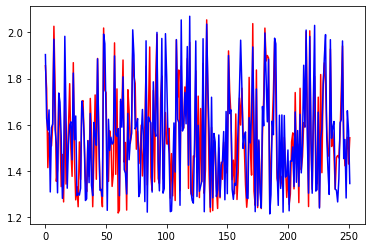

In [203]:
x_values = np.arange(len(preds_DNN_values))
y_pred_DNN = list(preds_DNN_values)
y_actual = list(y_test)

DNN = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Dense neural net) r2_score = 0.662',x_axis_label = '#',y_axis_label = 'rate')
DNN.line(x_values,y_pred_DNN,color="red",line_width=1,legend_label="Predicted")
DNN.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(DNN)

plt.plot(x_values,y_pred_DNN,color="red")
plt.plot(x_values,y_test,color="blue")

---
MULTIPLE LINEAR REGRESSION

In [168]:
sc = MinMaxScaler(feature_range=(0,1))

X = GBP_df.iloc[:,3:-1]
y = GBP_df.iloc[:,-1]

X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [169]:
regressor_MLR = LinearRegression()
regressor_MLR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [170]:
predictions_MLR = regressor_MLR.predict(X_test)

In [197]:
r2_score(predictions_MLR, y_test)

0.4089140104980029

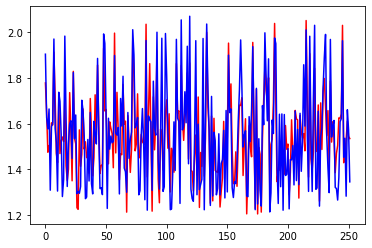

In [204]:
x_values = np.arange(len(predictions_MLR))
y_pred_MLR = list(predictions_MLR)
y_actual = list(y_test)

MLR = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Multiple Linear Regression) r2_score = 0.408',x_axis_label = '#',y_axis_label = 'rate')
MLR.line(x_values,y_pred_MLR,color="red",line_width=1,legend_label="Predicted")
MLR.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(MLR)

plt.plot(x_values,y_pred_MLR,color="red")
plt.plot(x_values,y_test,color="blue")

---
POLYNOMIAL MODEL

In [174]:
polynomial_preprocessor = PolynomialFeatures(degree = 2) # when the degree is augmented to 3 or 4 the results overfits : 2 is default
polynomial_preprocessor.fit(X)
X_polynomial_train = polynomial_preprocessor.transform(X_train)
X_polynomial_test = polynomial_preprocessor.transform(X_test)

In [175]:
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(X_polynomial_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [176]:
predictions_PM = polynomial_regressor.predict(X_polynomial_test)

In [199]:
r2_score(predictions_PM, y_test)

0.6054688945664055

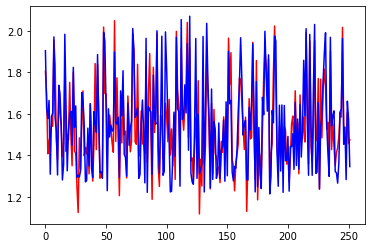

In [205]:
x_values = np.arange(len(predictions_PM))
y_pred_PM = list(predictions_PM)
y_actual = list(y_test)

PR = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Polynomial Regression) r2_score = 0.605',x_axis_label = '#',y_axis_label = 'rate')
PR.line(x_values,y_pred_PM,color="red",line_width=1,legend_label="Predicted")
PR.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(PR)

plt.plot(np.arange(len(predictions_PM)),predictions_PM,color="red")
plt.plot(np.arange(len(predictions_PM)),y_test,color="blue")

In [206]:
output_file('main.html')
plot = gridplot([[net_positions],[rates],[percentiles],[positions],[MLR],[PR],[DNN]])
show(plot)

## Adding MLR MLP and DNN predictions to the data frame

In [181]:
def mlr(data_frame):
    predictions_mlr_func = []
    for i in range(0,len(data_frame)):
        predictions_mlr_func.append(regressor_MLR.predict(sc.transform([[data_frame.loc[i][3],
                           data_frame.loc[i][4],
                           data_frame.loc[i][5],
                           data_frame.loc[i][6],
                           data_frame.loc[i][7],
                           data_frame.loc[i][8],
                           data_frame.loc[i][9],
                           data_frame.loc[i][10],
                           data_frame.loc[i][11],
                           data_frame.loc[i][12],
                           data_frame.loc[i][13]]])))
    
    return predictions_mlr_func

In [180]:
def mlp(data_frame):
    predictions_mlp_func = []
    for i in range(0,len(data_frame)):
        predictions_mlp_func.append(polynomial_regressor.predict(polynomial_preprocessor.transform([[data_frame.loc[i][3],
                                   data_frame.loc[i][4],
                                   data_frame.loc[i][5],
                                   data_frame.loc[i][6],
                                   data_frame.loc[i][7],
                                   data_frame.loc[i][8],
                                   data_frame.loc[i][9],
                                   data_frame.loc[i][10],
                                   data_frame.loc[i][11],
                                   data_frame.loc[i][12],
                                   data_frame.loc[i][13]]])))
    
    return predictions_mlp_func

In [183]:
X = GBP_df.iloc[:,3:-1]

X_predict = pd.DataFrame(data=sc.transform(X),
                         columns=tf_formated_cols,
                         index=X.index)

predict_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_predict,
                                                                batch_size=10,
                                                                num_epochs=1,
                                                                shuffle=False)

predicted_DNN_v2 = dnn_model.predict(input_fn=predict_function)
preds_DNN_values_v2_all = []

for element in list(predicted_DNN_v2):
    preds_DNN_values_v2_all.append(float(element['predictions']))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmprvviovzx\model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [184]:
GBP_df["DNN"] = preds_DNN_values_v2_all
GBP_df["MLR"] = mlr(GBP_df)
GBP_df["MLP"] = mlp(GBP_df)

In [186]:
GBP_df["MLR"] = GBP_df["MLR"].apply(lambda x: x[0])

In [187]:
GBP_df["MLP"] = GBP_df["MLP"].apply(lambda x: x[0])

In [189]:
GBP_df

,Date,Symbol,Release,Long,Short,Change Long,Change Short,Net positions,Total positions,Open interest,Percentile,Step,Adj OI,Percentile Adj OI,Rates dA,DNN,MLR,MLP
0,2021-03-09,BRITISH POUND STERLING,2021-03-16,61271,27360,-3867,-1696,33911,88631,181373,89.498807,1.0,0.186968,84.844869,1.38912,1.540607,1.615234,3.647089e+19
1,2021-03-02,BRITISH POUND STERLING,2021-03-09,65138,29056,-3128,-8232,36082,94194,169363,90.930788,1.0,0.213045,86.992840,1.38898,1.428114,1.629028,4.325593e+19
2,2021-02-02,BRITISH POUND STERLING,2021-02-09,53658,44042,6298,4647,9616,97700,161100,71.837709,1.0,0.059690,71.599045,1.39175,1.405305,1.564331,-6.082324e+18
3,2021-02-09,BRITISH POUND STERLING,2021-02-16,60513,39395,6855,-4647,21118,99908,170161,80.548926,1.0,0.124106,78.758950,1.38212,1.538610,1.560181,1.257058e+19
4,2021-02-16,BRITISH POUND STERLING,2021-02-23,60269,38102,-244,-1293,22167,98371,171218,81.264916,1.0,0.129467,79.594272,1.38997,1.459255,1.575317,1.589315e+19
5,2021-02-23,BRITISH POUND STERLING,2021-03-02,68266,37288,7997,-814,30978,105554,176721,87.828162,1.0,0.175293,84.486874,1.39486,1.502649,1.577393,1.967226e+19
6,2021-01-05,BRITISH POUND STERLING,2021-01-12,35526,31861,-209,958,3665,67387,143209,66.348449,1.0,0.025592,65.751790,1.36584,1.456464,1.625610,-1.767467e+17
7,2021-01-12,BRITISH POUND STERLING,2021-01-19,47935,34993,12409,3132,12942,82928,152924,75.178998,1.0,0.084630,74.821002,1.37349,1.423656,1.592163,-2.182747e+18
8,2021-01-19,BRITISH POUND STERLING,2021-01-26,45904,32199,-2031,-2794,13705,78103,147096,75.656325,1.0,0.093170,75.775656,1.38999,1.523446,1.611084,9.512025e+18
9,2021-01-26,BRITISH POUND STERLING,2021-02-02,47360,39395,1456,7196,7965,86755,154558,70.525060,1.0,0.051534,70.167064,1.40590,1.438255,1.597778,-4.271199e+18


## Simulating trades w/ machine learning models
It will simulate the trading of binary options  

['Date', 'Symbol','Release', 'Long', 'Short', 'Change Long', 'Change Short',
       'Net positions', 'Total positions', 'Open interest', 'Percentile',
       'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA']

In [76]:
symbol = "GBPUSD"
duration_after_release = 7

In [111]:
for i in range(0,len(GBP_df)):

    

Date                     2021-03-09 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2021-03-16 00:00:00
Long                                   61271
Short                                  27360
Change Long                            -3867
Change Short                           -1696
Net positions                          33911
Total positions                        88631
Open interest                         181373
Percentile                           89.4988
Step                                       1
Adj OI                              0.186968
Percentile Adj OI                    84.8449
Rates dA                             1.38912
Name: 0, dtype: object



1.38898



1.3891200000000001



[1.61523438]



Date                     2021-03-02 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2021-03-09 00:00:00
Long                                   65138
Short                                  29056
Change Long              

1.29792



1.29729



[1.51000977]



Date                     2020-09-15 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2020-09-22 00:00:00
Long                                   43801
Short                                  41508
Change Long                            -2789
Change Short                            7648
Net positions                           2293
Total positions                        85309
Open interest                         149989
Percentile                           65.1551
Step                                       1
Adj OI                             0.0152878
Percentile Adj OI                    65.0358
Rates dA                             1.30594
Name: 25, dtype: object



1.28867



1.30594



[1.60327148]



Date                     2020-09-22 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2020-09-29 00:00:00
Long                                   43487
Short                                  405

[1.48474121]



Date                     2020-02-18 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2020-02-25 00:00:00
Long                                   72784
Short                                  43526
Change Long                             7778
Change Short                            -396
Net positions                          29258
Total positions                       116310
Open interest                         216933
Percentile                           86.6348
Step                                       1
Adj OI                              0.134871
Percentile Adj OI                    79.9523
Rates dA                             1.22655
Name: 56, dtype: object



1.29948



1.22655



[1.49243164]



Date                     2020-02-25 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2020-03-03 00:00:00
Long                                   72667
Short                                  43069
Change Long        

[1.30395508]



Date                     2019-07-23 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2019-07-30 00:00:00
Long                                   31935
Short                                 110518
Change Long                            -3255
Change Short                           -1029
Net positions                         -78583
Total positions                       142453
Open interest                         248063
Percentile                           4.29594
Step                                      -1
Adj OI                             -0.316786
Percentile Adj OI                    13.3652
Rates dA                             1.21236
Name: 86, dtype: object



1.2436099999999999



1.2123599999999999



[1.31835938]



Date                     2019-07-30 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2019-08-06 00:00:00
Long                                   41367
Short                                 1315

[1.39257812]



Date                     2018-11-06 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2018-11-13 00:00:00
Long                                   31670
Short                                  88469
Change Long                            -4108
Change Short                             209
Net positions                         -56799
Total positions                       120139
Open interest                         227514
Percentile                           12.6492
Step                                      -1
Adj OI                             -0.249651
Percentile Adj OI                    22.5537
Rates dA                             1.27221
Name: 118, dtype: object



1.30952



1.27221



[1.39111328]



Date                     2018-11-13 00:00:00
Symbol               BRITISH POUND STERLING 
Release                  2018-11-20 00:00:00
Long                                   38606
Short                                  85713
Change Long       

TypeError: cannot convert the series to <class 'float'>

 ## Simulating trades w/out machine learning

> Ideas for backtesting  

* Trade the biggest net position always
* Trade when the change on one side is negative and the other is positivie
* Trade the biggest position when the changes on this are positive and the opposite position are negative

>Trades_columns = ["Date","Position","Symbol","Duration"]  
Trades_v1 = pd.DataFrame(columns=Trades_columns)  
Trades_v2 = pd.DataFrame(columns=Trades_columns)  
Trades_v3 = pd.DataFrame(columns=Trades_columns)  

>Currency_Columns = ["Date","Symbol","Long","Short","Change Long","Change Short","Net positions","Total positions"]   




In [104]:
symbol = "GBPUSD"
duration = 7

In [24]:
for i in range(0,len(GBPUSD_rates_frame)):
    dt_rates = dt(GBPUSD_rates_frame.iloc[i].time.year,GBPUSD_rates_frame.iloc[i].time.month,GBPUSD_rates_frame.iloc[i].time.day)
    
    for j in range(0,len(GBP_df)):
        dt_cot = dt(GBP_df.iloc[j].Date.year,GBP_df.iloc[j].Date.month,GBP_df.iloc[j].Date.day)
        
        if dt_cot == dt_rates:
            
            change_long = int(GBP_df.iloc[j][4])
            change_short = int(GBP_df.iloc[j][5])
            
            long = int(GBP_df.iloc[j].Long)
            short = int(GBP_df.iloc[j].Short)
            
            if long >= short:
                position = "Long"
                Trades_v1.loc[len(Trades_v1)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif long < short:
                position = "Short"
                Trades_v1.loc[len(Trades_v1)] = [dt_cot,position,symbol,duration,"NA"]
            
            if change_long <= 0 and change_short >= 0:
                position = "Short"
                Trades_v2.loc[len(Trades_v2)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif change_long >= 0 and change_short <= 0:
                position = "Long"
                Trades_v2.loc[len(Trades_v2)] = [dt_cot,position,symbol,duration,"NA"]
                
            if long >= short and change_long >= 0 and change_short <= 0:
                position = "Long"
                Trades_v3.loc[len(Trades_v3)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif long < short and change_long <= 0 and change_short >= 0:
                position = "Short"
                Trades_v3.loc[len(Trades_v3)] = [dt_cot,position,symbol,duration,"NA"]

## Describing trades

In [144]:
Trades_v3

,Date,Position,Symbol,Duration,Result
0,2005-02-15,Long,GBPUSD,7,Win
1,2005-02-22,Long,GBPUSD,7,Win
2,2005-04-05,Long,GBPUSD,7,Win
3,2005-05-10,Long,GBPUSD,7,Loose
4,2005-05-24,Short,GBPUSD,7,Win
5,2005-05-31,Short,GBPUSD,7,Loose
6,2005-06-14,Short,GBPUSD,7,Loose
7,2005-06-28,Short,GBPUSD,7,Win
8,2005-07-12,Short,GBPUSD,7,Win
9,2005-08-16,Long,GBPUSD,7,Loose


In [145]:
Trades_v2

,Date,Position,Symbol,Duration,Result
0,2005-01-18,Short,GBPUSD,7,Win
1,2005-01-25,Short,GBPUSD,7,Loose
2,2005-02-08,Short,GBPUSD,7,Loose
3,2005-02-15,Long,GBPUSD,7,Win
4,2005-02-22,Long,GBPUSD,7,Win
5,2005-03-22,Short,GBPUSD,7,Win
6,2005-03-29,Short,GBPUSD,7,Loose
7,2005-04-05,Long,GBPUSD,7,Win
8,2005-05-03,Short,GBPUSD,7,Win
9,2005-05-10,Long,GBPUSD,7,Loose


In [151]:
Trades_v1_s = Trades_v1

## Determine profitability

In [141]:
for i in range(0,len(Trades_v1)):
    
    position = Trades_v1.loc[i].Position
    
    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date + timedelta(days=Trades_v1.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date + timedelta(days=Trades_v1.loc[i].Duration)].iloc[0].close)
        except:
            continue
            
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v1.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v1.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v1.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v1.at[i,"Result"] = result 
    
    '''
    print ("\n============================")
    print(position)
    print(open_price)
    print(close_price)
    print(result)
    print ("============================\n")
    '''

In [142]:
for i in range(0,len(Trades_v2)):
    
    position = Trades_v2.loc[i].Position
    
    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date + timedelta(days=Trades_v2.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date + timedelta(days=Trades_v2.loc[i].Duration)].iloc[0].close)
        except:
            continue
            
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v2.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v2.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v2.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v2.at[i,"Result"] = result 
    

In [143]:
for i in range(0,len(Trades_v3)):
    
    position = Trades_v3.loc[i].Position

    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date + timedelta(days=Trades_v3.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date + timedelta(days=Trades_v3.loc[i].Duration)].iloc[0].close)
        except:
            continue
        
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v3.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v3.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v3.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v3.at[i,"Result"] = result         

In [152]:
for i in range(0,len(Trades_v1_s)):
    
    position = Trades_v1_s.loc[i].Position

    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=7)].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=7)].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=14)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=14)].iloc[0].close)
        except:
            continue
        
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v1_s.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v1_s.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v1_s.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v1_s.at[i,"Result"] = result      

## Calculating WinRate 

In [147]:
v1 = Trades_v1["Result"].tolist()
w = 0
t = len(v1)

for result in v1:
    if result == "Win":
        w+=1
w/t

0.46347305389221555

In [148]:
v2 = Trades_v2["Result"].tolist()
w = 0
t = len(v2)

for result in v2:
    if result == "Win":
        w+=1
w/t

0.4731457800511509

In [149]:
v3 = Trades_v3["Result"].tolist()
w = 0
t = len(v3)

for result in v3:
    if result == "Win":
        w+=1
w/t

0.4786729857819905

In [153]:
v1 = Trades_v1_s["Result"].tolist()
w = 0
t = len(v1)

for result in v1:
    if result == "Win":
        w+=1
w/t

0.46347305389221555

In [190]:
%store GBP_df

Stored 'GBP_df' (DataFrame)


In [193]:
%store GBPUSD_rates_frame

Stored 'GBPUSD_rates_frame' (DataFrame)
